## So sánh các phương pháp Under-sampling

Chúng ta sẽ xác định xem liệu các thuật toán undersampling khác nhau trong phần này có cải thiện chất lượng của Random Forest trong các tập dữ liệu khác nhau với các lớp mất cân bằng không.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [2]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    'iht': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# in ra lớp mất cân bằng
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



<details><summary> Gợi ý </summary>

[Counter()](https://docs.python.org/3/library/collections.html#collections.Counter)

</details>

In [5]:
# hàm huấn luyện random forest và đánh giá chất lượng

def run_randomForests(X_train, X_test, y_train, y_test):
    ## Yêu cầu 2:
    ## VIẾT CODE Ở ĐÂY:
    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    # tính xác suất của các dự đoán (sử dụng 'predict_proba')
    pred = rf.predict_proba(X_train)
    # sử dụng 'roc_auc_score' từ sklearn để in ra hệ số huấn luyện 
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    # tính xác suất của các dự đoán (sử dụng 'predict_proba')
    pred = rf.predict_proba(X_test)
    # sử dụng 'roc_auc_score' ừ sklearn để in ra hệ số kiểm tra
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

<details><summary> Gợi ý </summary>

[RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

</details>

In [6]:
# lưu kết quả
results_dict = {}
shapes_dict = {}

## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:

for dataset in datasets_ls:
    
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # load tập dữ liệu
    data = fetch_datasets()[dataset]
    
    # tách thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,  
    data.target, 
    test_size=0.3,
    random_state=0)
    
    # do nhiều kỹ thuật undersampling sử dụng KNN
    # chúng ta đặt biến trong cùng một tỷ lệ
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # lưu trữ kết quả
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # lấy lại mẫu
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
        
        # đánh giá chất lượng
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        # lưu trữ kết quả
        results_dict[dataset]['full_data'] = roc
        shapes_dict[dataset]['full_data'] = len(X_resampled)
        print()
        
    print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9765820711450264
Test set
Random Forests roc-auc: 0.9682620675579141

random
Train set
Random Forests roc-auc: 0.9963001503063939
Test set
Random Forests roc-auc: 0.9897438514134096

cnn
Train set
Random Forests roc-auc: 0.9682002467830072
Test set
Random Forests roc-auc: 0.986376160832738

tomek
Train set
Random Forests roc-auc: 0.9775250395105539
Test set
Random Forests roc-auc: 0.9718338605980202

oss
Train set
Random Forests roc-auc: 0.9788177918796639
Test set
Random Forests roc-auc: 0.9683130931727727

enn
Train set
Random Forests roc-auc: 0.9884902348035989
Test set
Random Forests roc-auc: 0.9671139912235943

renn
Train set
Random Forests roc-auc: 0.986973760804859
Test set
Random Forests roc-auc: 0.9650984794366771

allknn
Train set
Random Forests roc-auc: 0.984835952577888
Test set
Random Forests roc-auc: 0.9721400142871721

ncr
Train set
Random Forests roc-auc: 0.9786754643206256
Test set
Random Forests roc-auc: 0.96591488927441

<details><summary> Gợi ý </summary>

Sử dụng biến: ```dataset``` và ```undersampler```

</details>

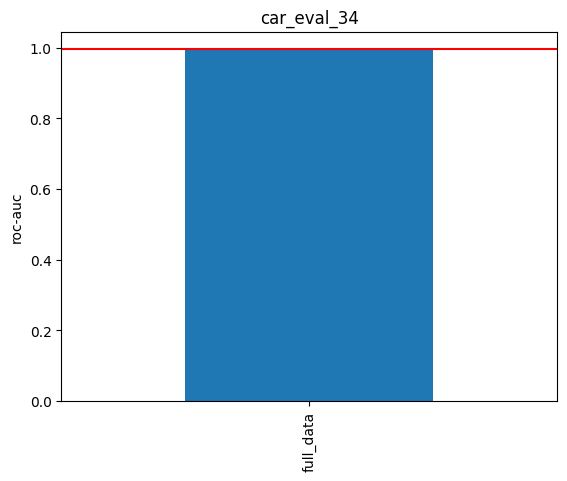

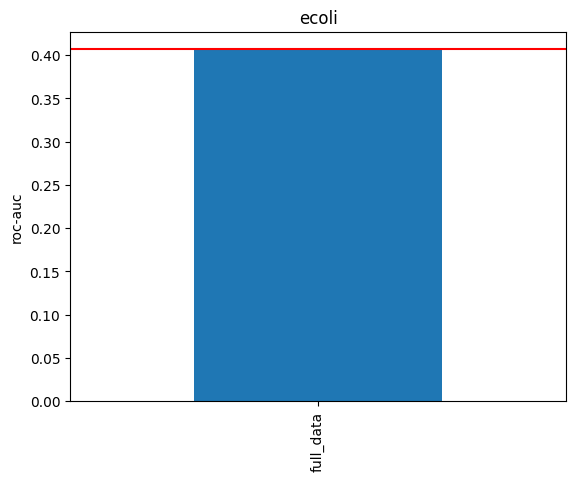

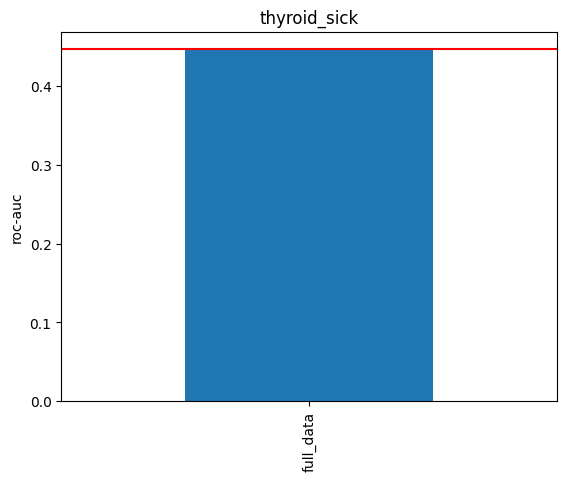

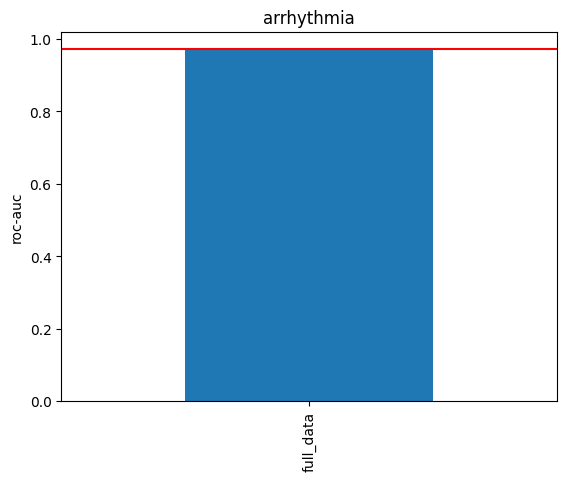

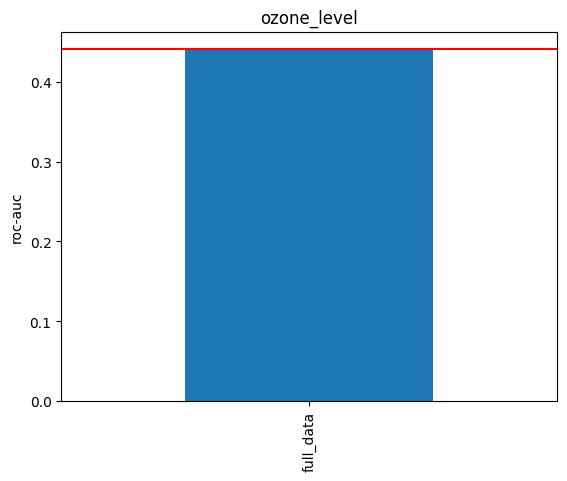

In [8]:
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
for dataset in datasets_ls:
    # hiển thị biểu đồ thanh 
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
#     plt.ylim(0.55, 0.9)
    # thêm một đường ngang qua trục
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

<details><summary> Gợi ý </summary>

[bar()](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.bar.html)

[axhline()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html)

</details>

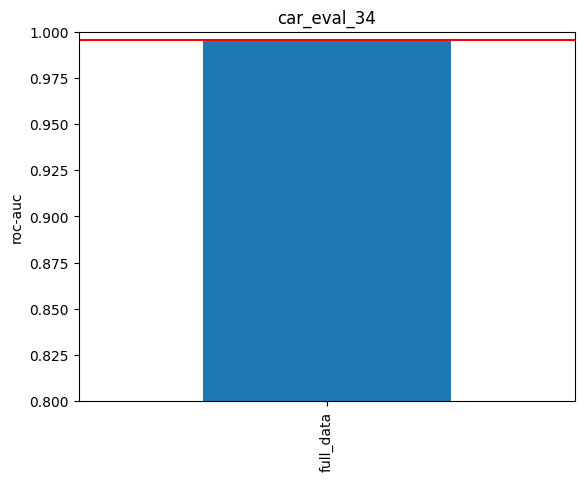

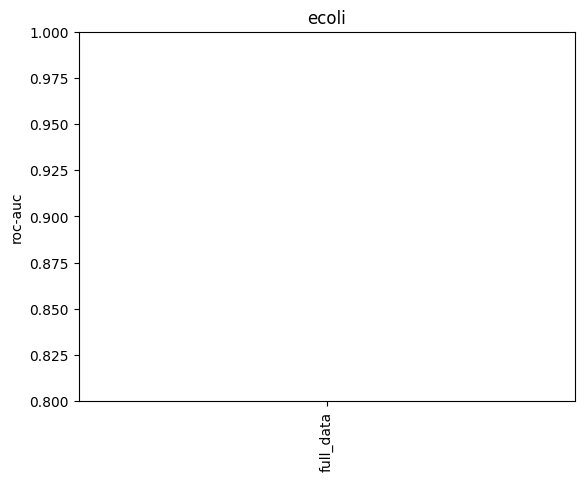

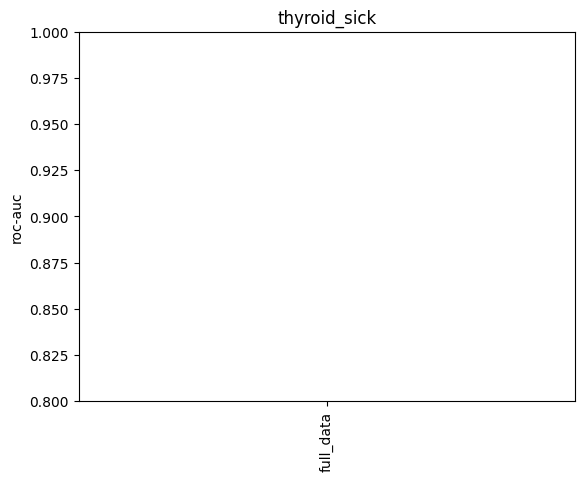

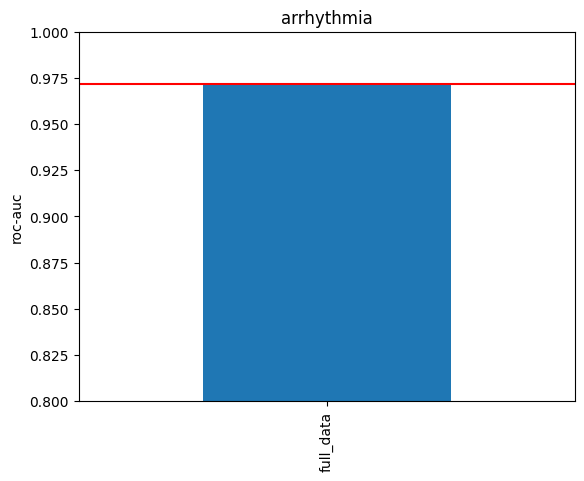

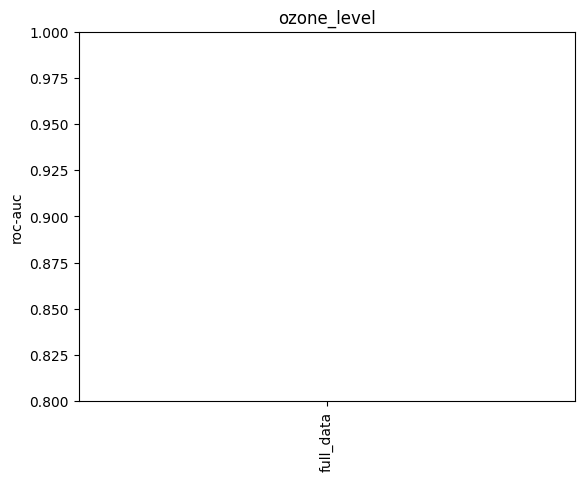

In [9]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:

for dataset in datasets_ls:
    # hiển thị biểu đồ thanh
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.8, 1)
    # thêm một đường ngang qua trục
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

<details><summary> Gợi ý </summary>

[bar()](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.bar.html)

[axhline()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html)

</details>

**Các kỹ thuật undersampling khác nhau hoạt động tốt nhất với các tập dữ liệu khác nhau.** 

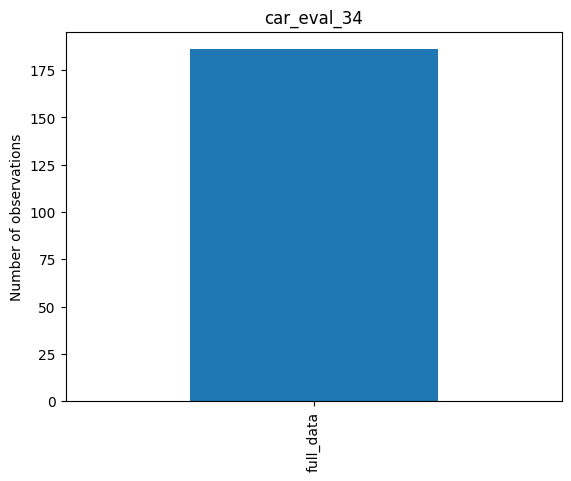

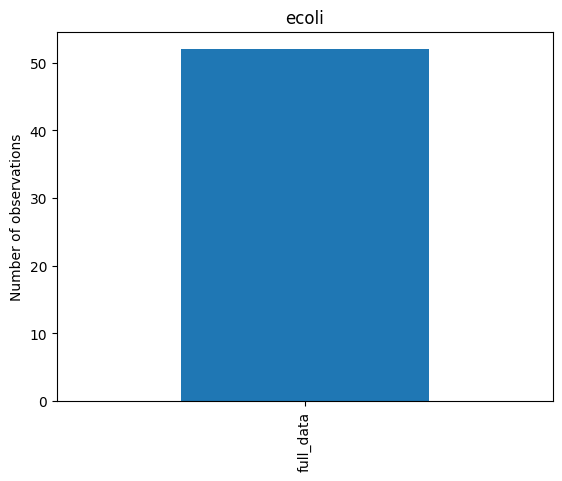

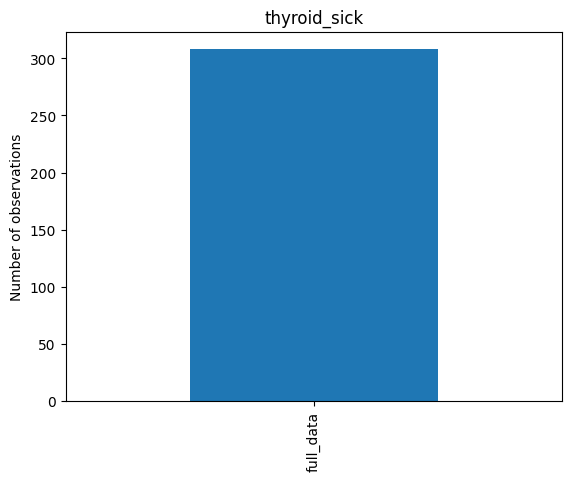

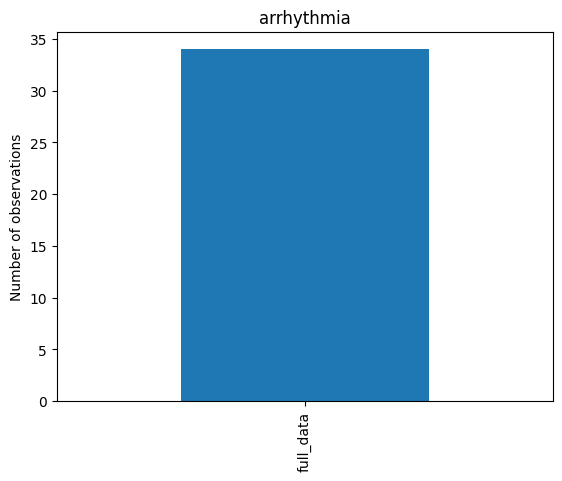

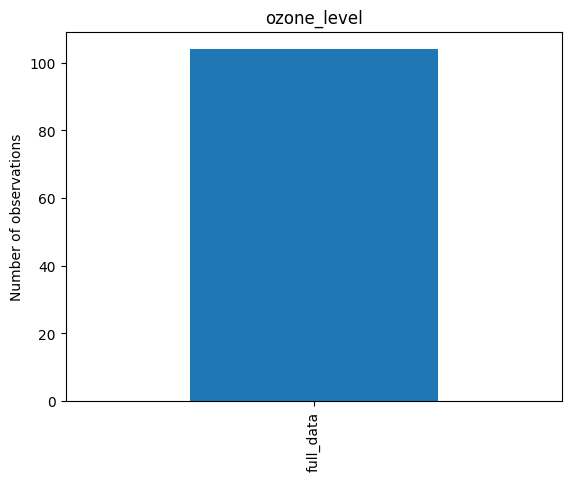

In [10]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:

for dataset in datasets_ls:
    # hiển thị biểu đồ thanh
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()